In [1]:
import numpy as np
import pandas as pd
import yt_dlp
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.metrics import structural_similarity as ssim
from skimage.feature import local_binary_pattern
import cv2
from tqdm import tqdm
import dlib
import librosa
from scipy.signal import correlate
from tqdm import tqdm
import concurrent.futures
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


c:\Users\juayk\anaconda3\envs\is217_env\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [11]:

PDD_PATH ='../PDD'

""" 
real_videos_path = "../archive/real"
fake_videos_path = "../archive/fake"
 """
# Function to get video metadata
def get_video_metadata(video_path):
    try:
        # Using ffmpeg to extract metadata

        if int(video_path[-6:-4]) in range(0,8):
            label = 'fake'
        else:
            label = 'real'
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None
        
        # Extract metadata
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        file_size = os.path.getsize(video_path) / (1024 * 1024)  # Convert bytes to MB
        
        cap.release()

        return {
            'filename': os.path.basename(video_path),
            'label':label,
            'width': width,
            'height': height,
            'duration_SEC': round(duration, 2),
            'frame_rate': round(fps, 2),
            'file_size_MB': round(file_size, 2)
        }
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
    return None

# Extract metadata for all videos in a folder
def extract_video_properties(folder_path):
    video_data = []
    for video_file in tqdm(os.listdir(folder_path), desc=f"Processing videos"):
        video_path = os.path.join(folder_path, video_file)
        metadata = get_video_metadata(video_path)
        if metadata:
            video_data.append(metadata)
    return video_data


# Convert to DataFrame
data = extract_video_properties(PDD_PATH)
df = pd.DataFrame(data)
# Display dataframe
df

Processing videos: 100%|██████████| 32/32 [00:00<00:00, 74.34it/s]


,filename,label,width,height,duration_SEC,frame_rate,file_size_MB
0,b-00.mp4,fake,640,360,23.80,30.00,0.76
1,b-01.mp4,fake,640,360,22.89,29.97,0.82
2,b-02.mp4,fake,640,360,24.84,25.00,0.77
3,b-03.mp4,fake,640,360,20.59,29.97,0.86
4,b-04.mp4,fake,640,360,21.02,29.97,1.23
5,b-05.mp4,fake,640,360,26.19,29.97,1.06
6,b-06.mp4,fake,640,360,14.71,29.97,0.60
7,b-07.mp4,fake,640,360,17.28,29.97,0.82
8,b-08.mp4,real,640,360,25.27,29.92,1.28
9,b-09.mp4,real,640,360,35.44,29.97,1.45


In [12]:
df.describe(include='all')

,filename,label,width,height,duration_SEC,frame_rate,file_size_MB
count,32,32,32.000000,32.0,32.000000,32.000000,32.000000
unique,32,2,NaN,NaN,NaN,NaN,NaN
top,b-00.mp4,fake,NaN,NaN,NaN,NaN,NaN
freq,1,16,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,631.250000,360.0,21.340938,29.042187,0.954375
std,NaN,NaN,49.497475,0.0,3.895236,1.972934,0.221955
min,NaN,NaN,360.000000,360.0,14.710000,25.000000,0.570000
25%,NaN,NaN,640.000000,360.0,20.080000,29.970000,0.807500
50%,NaN,NaN,640.000000,360.0,21.025000,29.970000,0.920000
75%,NaN,NaN,640.000000,360.0,22.395000,29.970000,1.070000


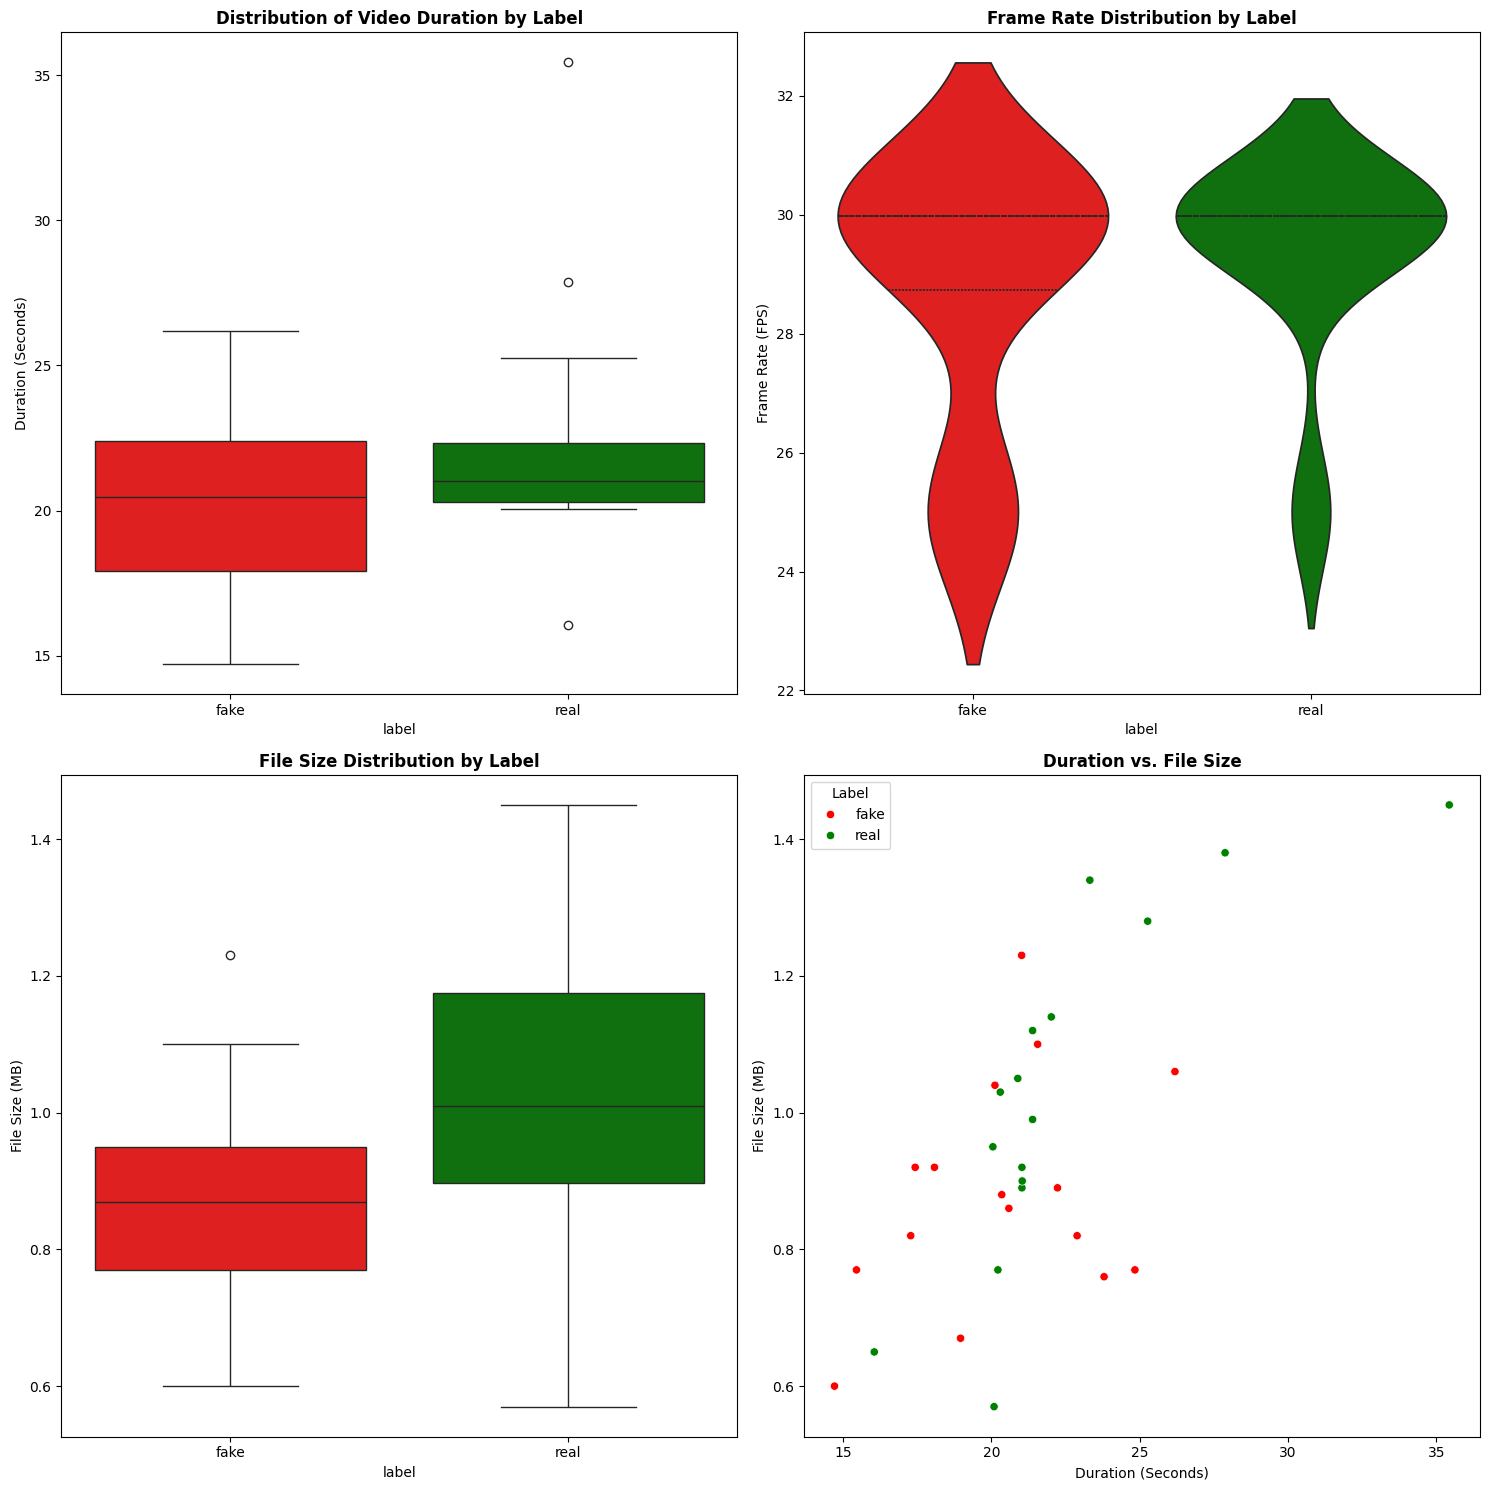

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Define the color palette
palette = {"real": "green", "fake": "red"}

# 1. Distribution of Video Durations
sns.boxplot(y="duration_SEC", x="label", hue="label", data=df, ax=axes[0, 0], palette=palette)
axes[0, 0].set_title("Distribution of Video Duration by Label", fontweight='bold')
axes[0, 0].set_ylabel("Duration (Seconds)")

# 2. Frame Rate Distribution
sns.violinplot(x="label", y="frame_rate", hue="label", data=df, palette=palette, ax=axes[0, 1], inner="quartile")
axes[0, 1].set_title("Frame Rate Distribution by Label", fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel("Frame Rate (FPS)", fontsize=10)

# 3. File Size Comparison
sns.boxplot(y="file_size_MB", x="label", hue="label", data=df, ax=axes[1, 0], palette=palette)
axes[1, 0].set_title("File Size Distribution by Label", fontweight='bold')
axes[1, 0].set_ylabel("File Size (MB)")

# 4. Scatter Plot: Duration vs. File Size
sns.scatterplot(x="duration_SEC", y="file_size_MB", hue="label", data=df, palette=palette, ax=axes[1, 1])
axes[1, 1].set_title("Duration vs. File Size", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Duration (Seconds)", fontsize=10)
axes[1, 1].set_ylabel("File Size (MB)", fontsize=10)
axes[1, 1].legend(title="Label")

plt.tight_layout()
plt.show()

In [19]:
PDD_PATH = '../PDD'  # Path to the PDD dataset folder
frame_output_path = "extracted_frames_PDD"

# Ensure output folder exists
os.makedirs(frame_output_path, exist_ok=True)

# Function to check if a video has already been processed
def are_frames_extracted(video_name, label):
    """Check if frames for a given video already exist."""
    for file in os.listdir(frame_output_path):
        if file.startswith(f"{label}_{video_name}_frame"):
            return True  # Frame already exists, skip processing
    return False  # No frames found, process video

# Function to extract frames at intervals from a video
def extract_frames(video_path, label, interval=60):  # Extract every N frames
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    frame_index = 0
    video_name = os.path.basename(video_path).split('.')[0]

    frames_already_extracted = are_frames_extracted(video_name, label)

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        if frame_index % interval == 0:  # Capture every 'interval' frame
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            frame_list.append(frame_gray)

            if not frames_already_extracted:
                frame_filename = f"{frame_output_path}/{label}_{video_name}_frame{frame_index}.jpg"
                cv2.imwrite(frame_filename, frame)

        frame_index += 1

    cap.release()
    return frame_list

# Compute histogram and SSIM between consecutive frames
def analyze_frames(frames):
    histograms = []
    ssim_values = []

    for i in range(len(frames) - 1):
        hist = cv2.calcHist([frames[i]], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms.append(hist)

        ssim_value = ssim(frames[i], frames[i + 1])
        ssim_values.append(ssim_value)

    return histograms, ssim_values

# Function to get video metadata directly from the video file
def get_video_metadata(video_path):
    try:
        # Determine the label based on the video filename
        if int(video_path[-6:-4]) in range(0, 8):  # Example: the filename range
            label = 'fake'
        else:
            label = 'real'
        
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None
        
        # Extract metadata
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        file_size = os.path.getsize(video_path) / (1024 * 1024)  # Convert bytes to MB
        
        cap.release()

        return {
            'filename': os.path.basename(video_path),
            'label': label,
            'width': width,
            'height': height,
            'duration_SEC': round(duration, 2),
            'frame_rate': round(fps, 2),
            'file_size_MB': round(file_size, 2)
        }
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
    return None

# Extract metadata and process videos in the folder
def extract_video_properties(folder_path):
    video_data = []
    
    for video_file in tqdm(os.listdir(folder_path), desc="Processing videos"):
        video_path = os.path.join(folder_path, video_file)
        metadata = get_video_metadata(video_path)
        if metadata:
            frames = extract_frames(video_path, metadata['label'])  # Extract frames for each video
            histograms, ssim_values = analyze_frames(frames)
            metadata['num_frames'] = len(frames)
            metadata['avg_ssim'] = np.mean(ssim_values) if ssim_values else 0
            video_data.append(metadata)
    
    return video_data

# Process videos in the PDD_PATH directory
video_data = extract_video_properties(PDD_PATH)

# Convert to DataFrame
df = pd.DataFrame(video_data)

# Check columns and display the DataFrame
print(df.columns)
print(df)

Processing videos: 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]

Index(['filename', 'label', 'width', 'height', 'duration_SEC', 'frame_rate',
       'file_size_MB', 'num_frames', 'avg_ssim'],
      dtype='object')
    filename label  width  height  duration_SEC  frame_rate  file_size_MB  \
0   b-00.mp4  fake    640     360         23.80       30.00          0.76   
1   b-01.mp4  fake    640     360         22.89       29.97          0.82   
2   b-02.mp4  fake    640     360         24.84       25.00          0.77   
3   b-03.mp4  fake    640     360         20.59       29.97          0.86   
4   b-04.mp4  fake    640     360         21.02       29.97          1.23   
5   b-05.mp4  fake    640     360         26.19       29.97          1.06   
6   b-06.mp4  fake    640     360         14.71       29.97          0.60   
7   b-07.mp4  fake    640     360         17.28       29.97          0.82   
8   b-08.mp4  real    640     360         25.27       29.92          1.28   
9   b-09.mp4  real    640     360         35.44       29.97          1.45   
10  

In [3]:

# Path to the folder containing the extracted frames
frames_folder = 'extracted_frames_PDD'

# List all files in the directory
files = os.listdir(frames_folder)

# Sort the files to ensure they are processed in order
files.sort()

# Initialize a counter for renaming
counter = 0

# Loop through all files and rename them
for file in files:
    # Check if the file has the correct extension and matches the expected naming pattern
    if file.endswith('.jpg'):
        # Define the new name using a sequential count format
        new_name = f"frame{counter}.jpg"

        # Define the full path for renaming
        old_path = os.path.join(frames_folder, file)
        new_path = os.path.join(frames_folder, new_name)

        # Rename the file
        os.rename(old_path, new_path)

        # Increment the counter for the next frame
        counter += 1

        print(f"Renamed: {file} -> {new_name}")


print("Renaming completed.")


Renamed: fake_b-00_frame0.jpg -> frame0.jpg
Renamed: fake_b-00_frame120.jpg -> frame1.jpg
Renamed: fake_b-00_frame180.jpg -> frame2.jpg
Renamed: fake_b-00_frame240.jpg -> frame3.jpg
Renamed: fake_b-00_frame300.jpg -> frame4.jpg
Renamed: fake_b-00_frame360.jpg -> frame5.jpg
Renamed: fake_b-00_frame420.jpg -> frame6.jpg
Renamed: fake_b-00_frame480.jpg -> frame7.jpg
Renamed: fake_b-00_frame540.jpg -> frame8.jpg
Renamed: fake_b-00_frame60.jpg -> frame9.jpg
Renamed: fake_b-00_frame600.jpg -> frame10.jpg
Renamed: fake_b-00_frame660.jpg -> frame11.jpg
Renamed: fake_b-01_frame0.jpg -> frame12.jpg
Renamed: fake_b-01_frame120.jpg -> frame13.jpg
Renamed: fake_b-01_frame180.jpg -> frame14.jpg
Renamed: fake_b-01_frame240.jpg -> frame15.jpg
Renamed: fake_b-01_frame300.jpg -> frame16.jpg
Renamed: fake_b-01_frame360.jpg -> frame17.jpg
Renamed: fake_b-01_frame420.jpg -> frame18.jpg
Renamed: fake_b-01_frame480.jpg -> frame19.jpg
Renamed: fake_b-01_frame540.jpg -> frame20.jpg
Renamed: fake_b-01_frame60.j

In [10]:
def extract_frames_from_video(video_path, num_frames=5):
    """
    Extracts `num_frames` evenly spaced frames from a video.
    Returns a list of frames.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < num_frames:
        print(f"Skipping {video_path}: Not enough frames ({total_frames} total)")
        cap.release()
        return []

    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for index in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames


In [114]:
def compute_texture_variance(frames):
    """
    Computes texture variance using Local Binary Patterns (LBP) from extracted frames.
    Returns the average texture variance.
    """
    texture_variances = []

    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect face
        faces = detector(gray)
        if len(faces) == 0:
            continue  # Skip frames where no face is detected

        for face in faces:
            landmarks = predictor(gray, face)

            # Extract key facial regions
            regions = [
                (landmarks.part(2).x, landmarks.part(2).y),  # Left cheek
                (landmarks.part(14).x, landmarks.part(14).y),  # Right cheek
                (landmarks.part(27).x, landmarks.part(27).y)  # Forehead
            ]

            # Compute LBP texture variance
            lbp = local_binary_pattern(gray, P=24, R=3, method="uniform")
            texture_values = [lbp[y, x] for x, y in regions]
            texture_variance = np.var(texture_values)
            texture_variances.append(texture_variance)

    if len(texture_variances) == 0:
        return None  # No valid frames found

    return np.mean(texture_variances)

In [115]:
def compute_saturation_variance(frames):
    """
    Computes saturation variance from HSV color space in extracted frames.
    Returns the average saturation variance.
    """
    saturation_variances = []

    for frame in frames:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Detect face
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        if len(faces) == 0:
            continue  # Skip frames where no face is detected

        for face in faces:
            landmarks = predictor(gray, face)

            # Extract key facial regions
            regions = [
                (landmarks.part(2).x, landmarks.part(2).y),  # Left cheek
                (landmarks.part(14).x, landmarks.part(14).y),  # Right cheek
                (landmarks.part(27).x, landmarks.part(27).y)  # Forehead
            ]

            # Compute Saturation variance
            saturation_values = [hsv[y, x, 1] for x, y in regions]
            saturation_variance = np.var(saturation_values)
            saturation_variances.append(saturation_variance)

    if len(saturation_variances) == 0:
        return None  # No valid frames found

    return np.mean(saturation_variances)

In [87]:
def compute_frame_differences(video_path):
    """
    Computes PSNR and SSIM differences between consecutive frames.
    """
    cap = cv2.VideoCapture(video_path)
    _, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    psnr_values = []
    ssim_values = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Compute PSNR
        mse = np.mean((prev_gray - gray) ** 2)
        psnr = 10 * np.log10(255**2 / mse) if mse > 0 else 100
        psnr_values.append(psnr)

        # Compute SSIM
        ssim_value = ssim(prev_gray, gray)
        ssim_values.append(ssim_value)

        prev_gray = gray

    cap.release()
    return np.mean(psnr_values), np.mean(ssim_values)

In [ ]:
def get_lip_movement(video_path, frame_skip=1):
    """
    Detects lip movement variance from a video.
    
    Optimizations:
    - Processes every 'frame_skip' frame instead of all frames.
    - Uses cv2.CascadeClassifier for faster initial face detection.
    - Resizes frames only when necessary.
    - Uses NumPy operations to speed up variance calculation.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open {video_path}")
        return None

    movements = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process only every nth frame
        if frame_count % frame_skip != 0:
            frame_count += 1
            continue

        try:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        except Exception as e:
            continue

        # Detect faces (faster method)
        faces = detector(gray)

        if len(faces) == 0:
            continue

        # Select the largest face (assumed to be the main speaker)
        faces = sorted(faces, key=lambda f: f.width() * f.height(), reverse=True)
        face = faces[0]

        try:
            landmarks = predictor(gray, face)
        except Exception as e:
            continue

        # Compute lip height
        lip_height = landmarks.part(66).y - landmarks.part(62).y
        movements.append(lip_height)

        frame_count += 1

    cap.release()

    # Ensure data exists before computing variance
    if len(movements) == 0:
        print(f"Warning: No lip movements detected in {video_path}")
        return None

    movements_array = np.array(movements)
    if np.var(movements_array) < 0.5:
        print(f"Warning: No significant lip movement detected in {video_path}")
        return None

    return movements_array

In [58]:
def detect_blinks(video_path):
    cap = cv2.VideoCapture(video_path)
    blink_count = 0
    closed_eyes_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        for face in faces:
            landmarks = predictor(gray, face)
            eye_aspect_ratio = (landmarks.part(41).y - landmarks.part(37).y) / (landmarks.part(40).y - landmarks.part(38).y)
            
            if eye_aspect_ratio < 0.2:
                closed_eyes_frames += 1
            else:
                if closed_eyes_frames > 2:
                    blink_count += 1
                closed_eyes_frames = 0

    cap.release()
    return blink_count

In [11]:
folder_path='../PDD'
data=[]
for filename in tqdm(os.listdir(folder_path), desc=f"Processing videos"):
    if filename.lower().endswith('.mp4'):
        video_path = os.path.join(folder_path, filename)
        audio_path = os.path.join(folder_path, filename.replace('.mp4', '.wav'))
        frames = extract_frames_from_video(video_path, num_frames=5)
        try:
            blink_count = detect_blinks(video_path)
            lip_movement = get_lip_movement(video_path,frame_skip=3)
            psnr_, ssim_ = compute_frame_differences(video_path)
            texture_avg = compute_texture_variance(frames)
            saturation_avg = compute_saturation_variance(frames)
            data.append({
                'filename': filename,
                'blink_count': blink_count,
                'lip_movement': lip_movement,
                'psnr': psnr_,
                'ssim': ssim_,
                'texture_score': texture_avg,
                'saturation_score': saturation_avg
            })
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Create a DataFrame
df_features = pd.DataFrame(data)
df_features

Processing videos:   6%|▋         | 2/32 [00:00<00:02, 11.18it/s]

Error processing b-00.mp4: name 'detect_blinks' is not defined
Error processing b-01.mp4: name 'detect_blinks' is not defined
Error processing b-02.mp4: name 'detect_blinks' is not defined


Processing videos:  12%|█▎        | 4/32 [00:00<00:02, 10.30it/s]

Error processing b-03.mp4: name 'detect_blinks' is not defined


Processing videos:  19%|█▉        | 6/32 [00:00<00:03,  7.60it/s]

Error processing b-04.mp4: name 'detect_blinks' is not defined
Error processing b-05.mp4: name 'detect_blinks' is not defined
Error processing b-06.mp4: name 'detect_blinks' is not defined


Processing videos:  31%|███▏      | 10/32 [00:01<00:02,  8.91it/s]

Error processing b-07.mp4: name 'detect_blinks' is not defined
Error processing b-08.mp4: name 'detect_blinks' is not defined
Error processing b-09.mp4: name 'detect_blinks' is not defined


Processing videos:  38%|███▊      | 12/32 [00:01<00:02,  9.96it/s]

Error processing b-10.mp4: name 'detect_blinks' is not defined
Error processing b-11.mp4: name 'detect_blinks' is not defined
Error processing b-12.mp4: name 'detect_blinks' is not defined


Processing videos:  50%|█████     | 16/32 [00:01<00:01, 10.02it/s]

Error processing b-13.mp4: name 'detect_blinks' is not defined
Error processing b-14.mp4: name 'detect_blinks' is not defined
Error processing b-15.mp4: name 'detect_blinks' is not defined


Processing videos:  56%|█████▋    | 18/32 [00:01<00:01, 10.11it/s]

Error processing t-00.mp4: name 'detect_blinks' is not defined
Error processing t-01.mp4: name 'detect_blinks' is not defined
Error processing t-02.mp4: name 'detect_blinks' is not defined


Processing videos:  69%|██████▉   | 22/32 [00:02<00:00, 11.26it/s]

Error processing t-03.mp4: name 'detect_blinks' is not defined
Error processing t-04.mp4: name 'detect_blinks' is not defined
Error processing t-05.mp4: name 'detect_blinks' is not defined


Processing videos:  75%|███████▌  | 24/32 [00:02<00:00, 10.48it/s]

Error processing t-06.mp4: name 'detect_blinks' is not defined
Error processing t-07.mp4: name 'detect_blinks' is not defined


Processing videos:  81%|████████▏ | 26/32 [00:02<00:00,  9.18it/s]

Error processing t-08.mp4: name 'detect_blinks' is not defined
Error processing t-09.mp4: name 'detect_blinks' is not defined


Processing videos:  88%|████████▊ | 28/32 [00:02<00:00,  8.92it/s]

Error processing t-10.mp4: name 'detect_blinks' is not defined
Error processing t-11.mp4: name 'detect_blinks' is not defined
Error processing t-12.mp4: name 'detect_blinks' is not defined


Processing videos:  97%|█████████▋| 31/32 [00:03<00:00,  8.65it/s]

Error processing t-13.mp4: name 'detect_blinks' is not defined
Error processing t-14.mp4: name 'detect_blinks' is not defined


Processing videos: 100%|██████████| 32/32 [00:03<00:00,  9.46it/s]

Error processing t-15.mp4: name 'detect_blinks' is not defined


""


In [136]:
df_features = df_features.merge(df[['filename','label']], on='filename')
df_features

,filename,blink_count,lip_movement,psnr,ssim,texture_score,saturation_score,label
0,b-08.mp4,0,"[-1, -1, -1, 0, 1, 1, 1, 3, 3, 3, 1, 2, 1, 1, ...",43.167854,0.980637,38.977778,357.244444,real
1,b-09.mp4,0,"[4, 2, 2, 3, 4, 2, 6, 5, 4, 2, 5, 2, 3, 2, 3, ...",44.693718,0.986833,20.000000,116.266667,real
2,t-09.mp4,0,"[3, 3, 3, 3, 3, 3, 4, 5, 4, 4, 3, 3, 3, 2, 3, ...",44.353299,0.985134,21.777778,892.311111,real
3,t-08.mp4,0,"[2, 2, 12, 4, 4, 9, 7, 5, 13, 9, 10, 1, -2, 4,...",43.772158,0.991705,45.611111,850.166667,real
4,b-15.mp4,0,"[1, 0, 2, 2, 4, 3, 1, 0, 1, 1, 2, 1, 1, 2, 5, ...",47.659382,0.994940,34.111111,23.055556,real
5,b-01.mp4,0,"[1, 2, 3, 1, 0, 1, 3, 3, 3, 5, 4, 4, 7, 5, 1, ...",45.735230,0.987080,52.000000,1592.277778,fake
6,t-11.mp4,0,"[4, 4, 3, 7, 3, 4, 6, 2, 3, 1, 3, 4, 5, 4, 5, ...",44.756564,0.981331,79.155556,130.444444,real
7,t-05.mp4,0,"[3, 3, 3, 3, 2, 2, 4, 6, 5, 4, 4, 3, 2, 5, 5, ...",43.558319,0.980824,80.888889,479.222222,fake
8,t-04.mp4,0,"[3, 4, 3, 5, 4, 4, 3, 4, 3, 3, 1, 2, 3, 2, 3, ...",44.195049,0.986379,47.155556,110.266667,fake
9,t-10.mp4,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 5, 4, ...",48.164326,0.993728,12.977778,1350.977778,real


/var/folders/0k/v3_hvd1d05lgdy_tnh64rz4h0000gn/T/ipykernel_37378/3007295020.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_lips_movements, x='label', y='lip_movement_diff', palette={"real": "green", "fake": "red"})


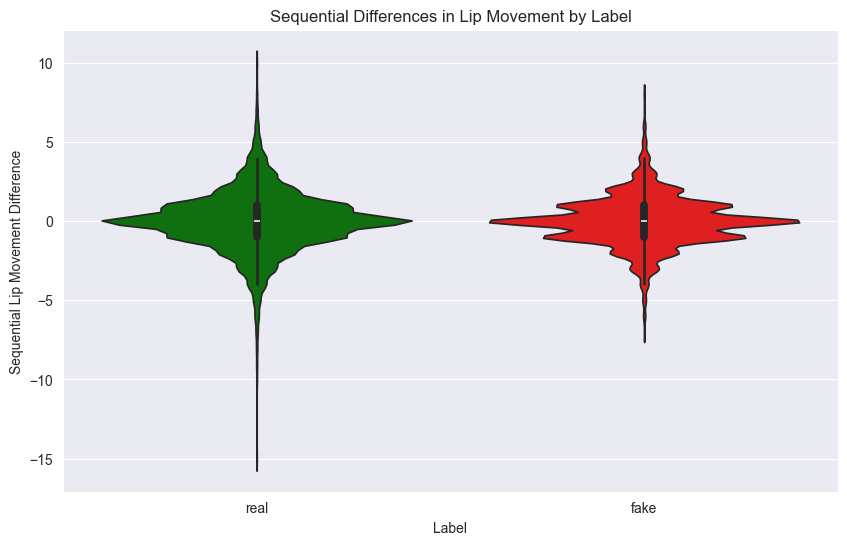

In [ ]:
df_features = df_features.dropna(subset=['lip_movement'])
df_features['lip_movement_diff'] = df_features['lip_movement'].apply(lambda x: np.diff(x) if isinstance(x, np.ndarray) and len(x) > 1 else None)

# Expand the differences while keeping labels
data_lips_movement = []
for _, row in df_features.iterrows():
    if row['lip_movement_diff'] is not None:
        for diff in row['lip_movement_diff']:
            data_lips_movement.append({'lip_movement_diff': diff, 'label': row['label']})
df_lips_movements = pd.DataFrame(data_lips_movement)

# Plot sequential lip movement differences with a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_lips_movements, x='label', y='lip_movement_diff', palette={"real": "green", "fake": "red"})
plt.title("Sequential Differences in Lip Movement by Label")
plt.xlabel("Label")
plt.ylabel("Sequential Lip Movement Difference")
plt.show()

/var/folders/0k/v3_hvd1d05lgdy_tnh64rz4h0000gn/T/ipykernel_37378/3149139123.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='label', y=col, palette={"real": "green", "fake": "red"})
/var/folders/0k/v3_hvd1d05lgdy_tnh64rz4h0000gn/T/ipykernel_37378/3149139123.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='label', y=col, palette={"real": "green", "fake": "red"})
/var/folders/0k/v3_hvd1d05lgdy_tnh64rz4h0000gn/T/ipykernel_37378/3149139123.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(d

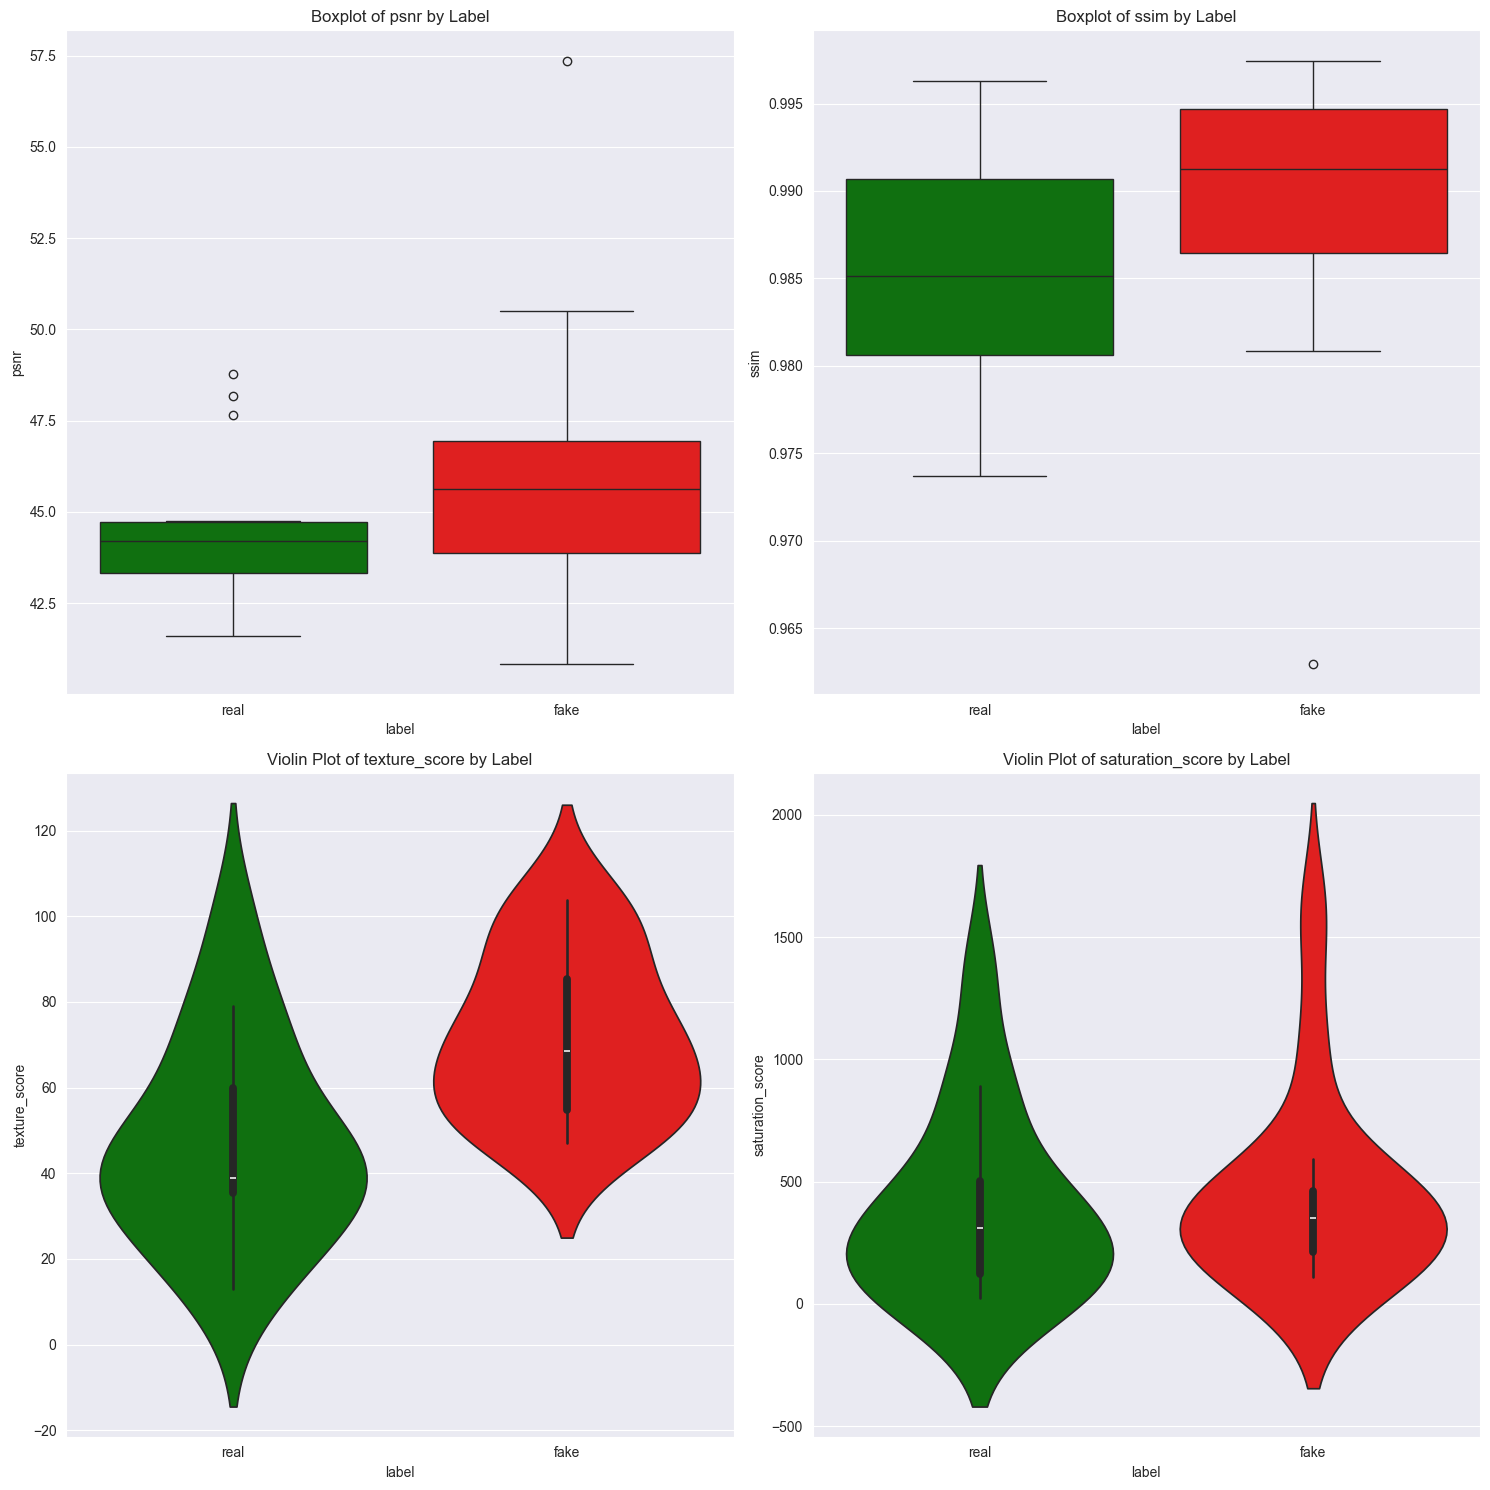

In [145]:
# Set figure size for plots
plt.figure(figsize=(15, 15))

# Define the columns to visualize
columns_to_plot = ['psnr', 'ssim', 'texture_score', 'saturation_score']

# Create different types of plots for each feature, separated by labels
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)

    if col in ['psnr', 'ssim']:
        sns.boxplot(data=df_features, x='label', y=col, palette={"real": "green", "fake": "red"})
        plt.title(f"Boxplot of {col} by Label")
    else:
        sns.violinplot(data=df_features, x='label', y=col, palette={"real": "green", "fake": "red"})
        plt.title(f"Violin Plot of {col} by Label")
    plt.ylabel(col)

# Adjust layout and display
plt.tight_layout()
plt.show()